# a

In [297]:
import numpy as np
from scipy import signal
from scipy.signal import cheby2, butter, filtfilt, sosfilt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
class PPGFeat:
    def __init__(self):
        # Initialize properties
        self.next = 1
        self.loadedData = None
        self.PPG_filtered = None
        self.Size_loaded_data = None
        self.SEG_min_max = None
        self.PPG_SEG = None
        self.APG_SEG = None
        self.Ssqi = None
        self.Sub_ID = None
        self.filter_sos = None
        self.g = None
        self.Fs = 125  # Default sampling frequency
        self.FL = 0.4   # Default low cutoff frequency
        self.FH = 8     # Default high cutoff frequency
        self.T2_5 = None
        self.SkipSsqiCheckBox  = False
        self.eEditField = None
        self.fEditField = None
        self.dEditField = None
        self.cEditField = None
        self.bEditField = None
        self.aEditField = None
        self.zEditField = None
        self.yEditField = None
        self.xEditField = None
        self.wEditField = None
        self.DEditField = None
        self.NEditField = None
        self.SEditField = None
        self.OEditField = None
        self.Min1EditField = None
        self.Min2EditField = None
        self.flg_initialized = None
    def zerocrossing(self, x):
        """Find zero crossing points in signal x"""
        inew = 0
        r = x
        loc = []
        
        for ch in range(1, len(r)):
            if ((r[ch-1] < 0 and r[ch] > 0) or 
                (r[ch-1] > 0 and r[ch] < 0)):
                loc.append(ch)
                inew += 1
                
        self.zero_c = loc
        return loc
    def check_sequence(self,*args):
        # 引数が1つ以下の場合はTrueを返す
        if len(args) <= 1:
            return True
        
        # 前の数値と現在の数値を比較
        for i in range(1, len(args)):
            # 昇順チェック
            if args[i] <= args[i-1]:
                return False
            # 差が3以上あるかチェック
            if args[i] - args[i-1] < 3:
                return False
        
        return True

    def cal_c_d(self):
        """Calculate c and d points in APG signal"""
        z_apg = self.zerocrossing(self.APG)
        self.JPG = np.diff(self.APG) * 1000
        self.JPG = pd.Series(self.JPG).rolling(window=85//8, center=True).mean().to_numpy()
        
        # Find local maxima and minima
        max_peaks, _ = signal.find_peaks(self.JPG, prominence=40, distance=6)
        min_peaks, _ = signal.find_peaks(-self.JPG, prominence=50, distance=6)
        
        max_value_jpg = max_peaks[:5]
        min_value_jpg = min_peaks[:5]
        z_jpg = self.zerocrossing(self.JPG)
        # print(len(min_value_jpg),self.JPG[min_value_jpg[1]])
        # Process c and d points based on conditions
        if len(min_value_jpg) > 1 and self.JPG[min_value_jpg[1]] < 0:
            if max_value_jpg[0] > min_value_jpg[0]:
                self.process_c_d_points(max_value_jpg[0], z_apg[1], z_jpg)
            elif max_value_jpg[1] > min_value_jpg[0]:
                self.process_c_d_points(max_value_jpg[1], z_apg[1], z_jpg)
            elif max_value_jpg[2] > min_value_jpg[0]:
                self.process_c_d_points(max_value_jpg[2], z_apg[1], z_jpg)
                
        elif len(min_value_jpg) > 1 and self.JPG[min_value_jpg[1]] > 0:
            if self.APG_maxima[1] < 0:
                self.process_c_d_points(self.APG_maxima[1], self.APG_minima[1], z_jpg)
            elif self.APG_maxima[1] > 0:
                self.process_c_d_points(
                    min_value_jpg[1] - self.T2_5,
                    min_value_jpg[1] + self.T2_5,
                    z_jpg
                )

    def process_c_d_points(self, c_point, d_point, z_jpg):
        """Helper function to process c and d points"""
        self.cEditField = c_point
        self.dEditField = d_point
        self.eEditField = z_jpg[2]
        f = z_jpg[3]
        self.fEditField = f
        self.NEditField = self.eEditField
        self.DEditField = f

    def LoadPPGButtonPushed(self, data,do_plot=True,skip_init=False):
        """Main function to load and process PPG data"""
        # Initialize counter
        if not skip_init:
            self.next = 1
            
            # Read filter parameters
            # self.Fs = self.FsHzEditField
            # self.FL = self.FLEditField
            # self.FH = self.FHEditField
            
            # Load data
            self.loadedData = np.array(data)
            
            # Get data dimensions
            self.Size_loaded_data = self.loadedData.shape
            
            # Initialize arrays
            self.SEG_min_max = np.zeros((self.Size_loaded_data[0], 3))
            self.PPG_filtered = np.zeros(self.Size_loaded_data)
            self.PPG_SEG = np.zeros((self.Size_loaded_data[0], 
                                    self.Size_loaded_data[1] - self.Size_loaded_data[1]//3))
            self.APG_SEG = np.zeros_like(self.PPG_SEG)
            self.PPG_filtered = self.loadedData
        # Create filter
        # sos = signal.cheby2(4, 20, [self.FL, self.FH], 
        #                   btype='band', fs=self.Fs, output='sos')
        
        # Apply filter to all data
        # for i in range(self.Size_loaded_data[0]):
        #     filtered_data = signal.sosfilt(sos, self.loadedData[i,:])
            
        #     # Normalize the data
        #     m = np.mean(filtered_data)
        #     st = np.std(filtered_data)
        #     self.PPG_filtered[i,:] = (filtered_data - m) / st
            
        # Handle Ssqi data if skip option is not checked
        if not self.SkipSsqiCheckBox:
            self.handle_ssqi_data()
        filtered_data = self.PPG_filtered[self.next-1, :]
        if do_plot:
            # Create figure and plot
            fig, ax = plt.subplots(figsize=(10, 6))
            ppg_line, = ax.plot(filtered_data)
            ax.grid(True)
            ax.set_title('Filtered PPG')
            ax.set_xlabel('Samples')
            ax.set_ylabel('Normalized values')
        
        # Find maxima and minima using find_peaks
        # For maxima
        max_peaks, max_properties = signal.find_peaks(
            filtered_data,
            prominence=0.1,
            distance=25,
            height=None
        )
        # Limit to 10 peaks
        if len(max_peaks) > 15:
            # Sort by prominence and take top 10
            max_prominences = max_properties['prominences']
            top_10_max = np.argsort(max_prominences)[-15:]
            max_peaks = max_peaks[top_10_max]
        
        # For minima
        min_peaks, min_properties = signal.find_peaks(
            -filtered_data,  # Invert signal to find minima
            prominence=0.1,
            distance=25,
            height=None
        )
        # Limit to 10 peaks
        if len(min_peaks) > 15:
            # Sort by prominence and take top 10
            min_prominences = min_properties['prominences']
            top_10_min = np.argsort(min_prominences)[-15:]
            min_peaks = min_peaks[top_10_min]
        
        # Get values at maxima and minima points
        max_values = filtered_data[max_peaks]
        min_values = filtered_data[min_peaks]
        # Plot maxima points with annotations
        if do_plot:
            if len(max_peaks) > 0:
                ax.plot(max_peaks, max_values, 'r^', markersize=10)
                for i, (x, y) in enumerate(zip(max_peaks, max_values)):
                    ax.annotate(
                        f'({x}, {y:.2f})',
                        (x, y),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8,
                        bbox=dict(
                            boxstyle='round,pad=0.5',
                            fc='yellow',
                            alpha=0.5
                        )
                )
        
            # Plot minima points with annotations
            if len(min_peaks) > 0:
                ax.plot(min_peaks, min_values, 'gv', markersize=10)
                for i, (x, y) in enumerate(zip(min_peaks, min_values)):
                    ax.annotate(
                        f'({x}, {y:.2f})',
                        (x, y),
                        xytext=(5, -15),  # Offset below point
                        textcoords='offset points',
                        fontsize=8,
                        bbox=dict(
                            boxstyle='round,pad=0.5',
                            fc='yellow',
                            alpha=0.5
                        )
                    )
        # Store peaks for later use
        self.ppg_max_peaks = max_peaks
        self.ppg_min_peaks = min_peaks
        self.ppg_max_values = max_values
        self.ppg_min_values = min_values
        # Add zoom and pan capabilities
        # plt.gcf().canvas.toolbar.pan()
        # plt.gcf().canvas.toolbar.zoom()
        if do_plot:
            plt.show()
            
        self.flg_initialized = True
        # Set Min1 and Min2 values if minima points exist
    def update(self):
        if not self.flg_initialized:
            self.ppg_min_peaks = self.ppg_min_peaks[1:]
        else:
            self.flg_initialized = False
        if len(self.ppg_min_peaks) >= 2:
            print("minima 2 exist, num of peaks:",len(self.ppg_min_peaks))
            self.Min1EditField = self.ppg_min_peaks[0]
            self.Min2EditField = self.ppg_min_peaks[1]
        else:
            print("minima 2 doesn't exist, num of peaks:",len(self.ppg_min_peaks))
            return False
            
        # Initialize variables
        self.OSND = np.zeros(4)
        self.WXYZ = np.zeros(4)
        self.abcde = np.zeros(5)
        self.feature = np.zeros((219, 30))
        self.c_d_APG = np.zeros(219)
        return True

    def handle_ssqi_data(self):
        """Handle Ssqi data initialization"""
        A = np.ones(self.Size_loaded_data[0])
        B = np.arange(1, self.Size_loaded_data[0] + 1)
        self.Ssqi = np.column_stack((A, B))
        
        self.SsqiEditField = self.Ssqi[self.next-1, 0]
        self.Sub_ID = self.Ssqi[self.next-1, 1]
        self.IDEditField = self.Sub_ID
    def APG_c_d_test(self):
        """Test for presence of c and d points in APG"""
        self.c_d_not = 0
        if len(self.APG_maxima) >1:
            if self.APG[self.APG_maxima[1]] > 0:  # c and d NOT present in APG
                self.c_d_not = 1
                self.c_d_APG[self.next-1] = 0
                self.canddpresentEditField = self.c_d_APG[self.next-1]
                self.cal_c_d()
            
        # Updated on 15th march
        elif (self.APG[self.APG_maxima[1]] < 0 and 
              (self.APG_maxima[1] - self.APG_minima[1]) < 20):  # c and d present in APG
            self.c_d_not = 0
            self.NEditField = self.APG_maxima[2]
            self.DEditField = self.APG_minima[2]
            self.cEditField = self.APG_maxima[1]
            self.dEditField = self.APG_minima[1]
            self.eEditField = self.APG_maxima[2]
            self.fEditField = self.APG_minima[2]
            self.c_d_APG[self.next-1] = 1
            self.canddpresentEditField = self.c_d_APG[self.next-1]
        else:  # Changed 15th march
            self.c_d_APG[self.next-1] = 1
            self.canddpresentEditField = self.c_d_APG[self.next-1]
            self.cal_c_d()

    def PlotButtonPushed(self,do_plot=True):
        """Plot and analyze PPG segments"""
        # Set plot lamp indicator
        self.PlotpressedLamp = 'g'
        
        # Get segment using manual input values
        min1 = self.Min1EditField - 2
        min2 = self.Min2EditField + 2
        self.seg = self.PPG_filtered[self.next-1, min1:min2]
        
        # Calculate 2.5% of T
        self.T2_5 = int(((min2 - min1 - 4) / 100) * 2.5)
        
        # Calculate and filter VPG
        self.VPG = np.diff(self.seg) * 1000
        # Smooth data using moving average (50/8 ms) 
        window = np.ones(6) / 6
        self.VPG = np.convolve(self.VPG, window, mode='same')
        
        # Calculate and filter APG
        self.APG = np.diff(self.VPG) * 1000
        # Smooth data using moving average (65/8 ms) 
        window = np.ones(8) / 8
        self.APG = np.convolve(self.APG, window, mode='same')
        
        # Create matrix for segment information
        self.SEG_min_max[self.next-1] = [self.Sub_ID, min1, min2]
        
        # Find peaks for PPG segment
        PPG_peaks_max, _ = find_peaks(self.seg, prominence=0.1, distance=2)
        PPG_peaks_min, _ = find_peaks(-self.seg, prominence=0.01, distance=2)
        
        # Find peaks for VPG
        VPG_peaks_max, _ = find_peaks(self.VPG, prominence=0.2, distance=7)
        VPG_peaks_min, _ = find_peaks(-self.VPG, prominence=0.2, distance=7)
        
        # Find peaks for APG
        APG_peaks_max, _ = find_peaks(self.APG, prominence=1.5, distance=7)
        APG_peaks_min, _ = find_peaks(-self.APG, prominence=1.5, distance=7)
        # Handle close points in APG
        if len(VPG_peaks_min) > 1 and len(VPG_peaks_max) > 0:
            if VPG_peaks_min[0] < VPG_peaks_max[0]:
                VPG_peaks_min = VPG_peaks_min[1:]
        # Handle close points in APG
        if len(APG_peaks_min) > 1 and len(APG_peaks_max) > 0:
            if abs(APG_peaks_min[0] - APG_peaks_max[0]) <= 7:
                APG_peaks_min = APG_peaks_min[1:]
        if(len(PPG_peaks_max)==0):
            self.plot_safe(PPG_peaks_max, PPG_peaks_min, 
                    VPG_peaks_max, VPG_peaks_min,
                    APG_peaks_max, APG_peaks_min)
        if(len(PPG_peaks_min)==0):
            PPG_peaks_min= np.array([np.argmin(self.seg[:PPG_peaks_max[0]])])
                # Store APG maxima and minima
        self.APG_maxima = APG_peaks_max
        self.APG_minima = APG_peaks_min
        
        # Set feature points
        self.OEditField = PPG_peaks_min[0]
        self.SEditField = PPG_peaks_max[0]
        
        # Test for c and d presence
        self.APG_c_d_test()
        
        # Set VPG points
        self.wEditField = VPG_peaks_max[0]
        self.xEditField = PPG_peaks_max[0]
        self.yEditField = VPG_peaks_min[0]
        self.zEditField = VPG_peaks_max[1]
        
        # Set APG points
        self.aEditField = APG_peaks_max[0]
        self.bEditField = APG_peaks_min[0]
        self.is_valid = self.check_sequence(
            self.OEditField,self.SEditField,self.NEditField,self.DEditField) and self.check_sequence(
            self.wEditField,self.xEditField,self.yEditField,self.zEditField) and self.check_sequence(
            self.aEditField,self.bEditField,self.cEditField,self.dEditField,self.eEditField,self.fEditField)
        self.is_valid = self.is_valid and len(PPG_peaks_min)>0
        # Store feature values
        # self.store_feature_values()
        if do_plot:
        # Plot results
            self.plot_results(PPG_peaks_max, PPG_peaks_min, 
                                VPG_peaks_max, VPG_peaks_min,
                                APG_peaks_max, APG_peaks_min)
    def store_feature_values_to_df(self):
        """Store feature values in a pandas DataFrame"""
        features = {
            'next': self.next-1,
            'min_t': self.Min1EditField,
            'max_t': self.Min2EditField,
            'valid':self.is_valid,
            # 'O': self.seg[self.SEditField],
            # 'S': self.seg[self.OEditField],
            # 'N': self.seg[self.eEditField],
            # 'D': self.seg[self.fEditField],
            # 'W': self.VPG[self.wEditField],
            # 'X': self.VPG[self.xEditField],
            # 'Y': self.VPG[self.yEditField],
            # 'Z': self.VPG[self.zEditField],
            # 'a': self.APG[self.aEditField],
            # 'b': self.APG[self.bEditField],
            # 'c': self.APG[self.cEditField],
            # 'd': self.APG[self.dEditField],
            # 'e': self.APG[self.eEditField],
            # 'f': self.APG[self.fEditField],
            'O_t': self.SEditField,
            'S_t': self.OEditField,
            'N_t': self.eEditField,
            'D_t': self.fEditField,
            'W_t': self.wEditField,
            'X_t': self.xEditField,
            'Y_t': self.yEditField,
            'Z_t': self.zEditField,
            'a_t': self.aEditField,
            'b_t': self.bEditField,
            'c_t': self.cEditField,
            'd_t': self.dEditField,
            'e_t': self.eEditField,
            'f_t': self.fEditField
        }
        
        # Create DataFrame with a single row
        df = pd.DataFrame([features])
        return df
        
    def store_feature_values(self):
        """Store feature values for all waveforms"""
        # PPG features
        self.OSND = [
            self.seg[self.OEditField],
            self.seg[self.SEditField],
            self.seg[self.NEditField],
            self.seg[self.DEditField]
        ]
        
        # VPG features
        self.WXYZ = [
            self.VPG[self.wEditField],
            self.VPG[self.xEditField],
            self.VPG[self.yEditField],
            self.VPG[self.zEditField]
        ]
        
        # APG features
        self.abcde = [
            self.APG[self.aEditField],
            self.APG[self.bEditField],
            self.APG[self.cEditField],
            self.APG[self.dEditField],
            self.APG[self.eEditField]
        ]
        
        # Time variables
        self.OSND_time = [self.OEditField, self.SEditField, 
                         self.NEditField, self.DEditField]
        self.WXYZ_time = [self.wEditField, self.xEditField, 
                         self.yEditField, self.zEditField]
        self.abcde_time = [self.aEditField, self.bEditField,
                          self.cEditField, self.dEditField, 
                          self.eEditField]
        
        # Additional features
        F_Value = self.APG[self.fEditField]
        F_t = self.fEditField
        O_next_t = ((self.Min2EditField - self.Min1EditField) + 3)
        O_next = self.seg[O_next_t]
        flat_feature = []

        for item in (
            self.OSND +
            [O_next] +
            self.WXYZ +
            self.abcde +
            [F_Value] +
            self.OSND_time +
            [O_next_t] +
            self.WXYZ_time +
            self.abcde_time +
            [F_t]
        ):
            # print(type(item),end=" ")
            if isinstance(item, (list, np.ndarray)):  # ネストされたものは展開
                flat_feature.extend(item)
            else:
                flat_feature.append(item)
        # Store all features
        self.feature[self.next-1,:] = np.array(flat_feature)
        return 
    def plot_safe(self, PPG_peaks_max, PPG_peaks_min, 
                    VPG_peaks_max, VPG_peaks_min,
                    APG_peaks_max, APG_peaks_min):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16))
        print(len(PPG_peaks_max),len(PPG_peaks_min),len(VPG_peaks_max),len(VPG_peaks_min),len(APG_peaks_max),len(APG_peaks_min))

        # Plot PPG
        ax1.plot(self.seg)
        ax1.plot(PPG_peaks_max, self.seg[PPG_peaks_max], "x",label="local maxima")
        ax1.plot(PPG_peaks_min, self.seg[PPG_peaks_min], "o",label="local minima")
        ax1.axhline(y=0, color='r', linestyle='--')
        ax1.legend()
        ax1.set_title('PPG Segment')
        ax1.grid(True)
        
        # Plot VPG
        ax2.plot(self.VPG)
        ax2.plot(VPG_peaks_max, self.VPG[VPG_peaks_max], "x",label="local maxima")
        ax2.plot(VPG_peaks_min, self.VPG[VPG_peaks_min], "o",label="local minima")

        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.legend()
        ax2.set_title('VPG')
        ax2.grid(True)
        
        # Plot APG
        ax3.plot(self.APG)
        ax3.plot(APG_peaks_max, self.APG[APG_peaks_max], "x",label="local maxima")
        ax3.plot(APG_peaks_min, self.APG[APG_peaks_min], "o",label="local minima")

        ax3.axhline(y=0, color='r', linestyle='--')
        ax3.set_title('APG')
        ax3.grid(True)
        ax3.legend()        
        
        ax4.plot(self.JPG)
        ax4.axhline(y=0, color='r', linestyle='--')
        ax4.set_title('JPG')
        ax4.grid(True)
        ax4.legend()
        plt.tight_layout()
        plt.show()
        plt.tight_layout()
        plt.show()
    def plot_results(self, PPG_peaks_max, PPG_peaks_min, 
                    VPG_peaks_max, VPG_peaks_min,
                    APG_peaks_max, APG_peaks_min):
        """Plot all waveforms with their features"""
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16))
        print(len(PPG_peaks_max),len(PPG_peaks_min),len(VPG_peaks_max),len(VPG_peaks_min),len(APG_peaks_max),len(APG_peaks_min))

        # Plot PPG
        ax1.plot(self.seg)
        ax1.plot(PPG_peaks_max[0], self.seg[PPG_peaks_max[0]], "s",color="black")
        ax1.annotate('S', (PPG_peaks_max[0], self.seg[PPG_peaks_max[0]]), xytext=(5,5), textcoords='offset points')
        ax1.plot(PPG_peaks_min[0], self.seg[PPG_peaks_min[0]], "s",color="black")
        ax1.annotate('O', (PPG_peaks_min[0], self.seg[PPG_peaks_min[0]]), xytext=(5,5), textcoords='offset points')
        ax1.plot(self.eEditField, self.seg[self.eEditField], "s",color="brown")
        ax1.annotate('N', (self.eEditField, self.seg[self.eEditField]), xytext=(5,5), textcoords='offset points')
        ax1.plot(self.fEditField, self.seg[self.fEditField], "s",color="brown")
        ax1.annotate('D', (self.fEditField, self.seg[self.fEditField]), xytext=(5,5), textcoords='offset points')

        ax1.axhline(y=0, color='r', linestyle='--')
        ax1.legend()
        ax1.set_title('PPG Segment')
        ax1.grid(True)
        
        # Plot VPG
        ax2.plot(self.VPG)
        ax2.plot(self.wEditField, self.VPG[self.wEditField], "s",color="black")
        ax2.annotate('W', (self.wEditField, self.VPG[self.wEditField]), xytext=(5,5), textcoords='offset points')
        ax2.plot(self.xEditField, self.VPG[self.xEditField], "s",color="black")
        ax2.annotate('X', (self.xEditField, self.VPG[self.xEditField]), xytext=(5,5), textcoords='offset points')
        ax2.plot(self.yEditField, self.VPG[self.yEditField], "s",color="gray")
        ax2.annotate('Y', (self.yEditField, self.VPG[self.yEditField]), xytext=(5,5), textcoords='offset points')
        ax2.plot(self.zEditField, self.VPG[self.zEditField], "s",color="gray")
        ax2.annotate('Z', (self.zEditField, self.VPG[self.zEditField]), xytext=(5,5), textcoords='offset points')
        ax2.plot(VPG_peaks_max, self.VPG[VPG_peaks_max], "x",label="local maxima")
        ax2.plot(VPG_peaks_min, self.VPG[VPG_peaks_min], "o",label="local minima")

        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.legend()
        ax2.set_title('VPG')
        ax2.grid(True)
        
        # Plot APG
        ax3.plot(self.APG)
        ax3.plot(self.aEditField, self.APG[self.aEditField], "s",color="black")
        ax3.annotate('a', (self.aEditField, self.APG[self.aEditField]), xytext=(5,5), textcoords='offset points')
        ax3.plot(self.bEditField, self.APG[self.bEditField], "s",color="black")
        ax3.annotate('b', (self.bEditField, self.APG[self.bEditField]), xytext=(5,5), textcoords='offset points')
        ax3.plot(self.cEditField, self.APG[self.cEditField], "s",color="gray")
        ax3.annotate('c', (self.cEditField, self.APG[self.cEditField]), xytext=(5,5), textcoords='offset points')
        ax3.plot(self.dEditField, self.APG[self.dEditField], "s",color="gray")
        ax3.annotate('d', (self.dEditField, self.APG[self.dEditField]), xytext=(5,5), textcoords='offset points')
        ax3.plot(self.eEditField, self.APG[self.eEditField], "s",color="brown")
        ax3.annotate('e', (self.eEditField, self.APG[self.eEditField]), xytext=(5,5), textcoords='offset points')
        ax3.plot(self.fEditField, self.APG[self.fEditField], "s",color="brown")
        ax3.annotate('f', (self.fEditField, self.APG[self.fEditField]), xytext=(5,5), textcoords='offset points')
        ax3.plot(APG_peaks_max, self.APG[APG_peaks_max], "x",label="local maxima")
        ax3.plot(APG_peaks_min, self.APG[APG_peaks_min], "o",label="local minima")

        ax3.axhline(y=0, color='r', linestyle='--')
        ax3.set_title('APG')
        ax3.grid(True)
        ax3.legend()        
        
        ax4.plot(self.JPG)
        ax4.plot(self.eEditField, self.JPG[self.eEditField], "s",color="brown")
        ax4.annotate('e', (self.eEditField, self.JPG[self.eEditField]), xytext=(5,5), textcoords='offset points')
        ax4.plot(self.fEditField, self.JPG[self.fEditField], "s",color="brown")
        ax4.annotate('f', (self.fEditField, self.JPG[self.fEditField]), xytext=(5,5), textcoords='offset points')

        ax4.axhline(y=0, color='r', linestyle='--')
        ax4.set_title('JPG')
        ax4.grid(True)
        ax4.legend()
        plt.tight_layout()
        plt.show()
        plt.tight_layout()
        plt.show()
        
        # Store segments
        pad_length =  self.PPG_SEG[self.next-1].shape[0]-self.seg.shape[0]
        print(pad_length,self.Size_loaded_data[1],"array ", self.PPG_SEG[self.next-1].shape,"seg",self.seg.shape)
        self.PPG_SEG[self.next-1] = np.pad(self.seg, (0, pad_length))
        self.APG_SEG[self.next-1] = np.pad(self.APG, (0, pad_length+2))

In [96]:
data = np.load("../data/processed/BP_npy/PulseDB/test.npy")[:,1]
data.shape

(111600, 1250)

In [97]:
data2 = data[:1000]
data2.shape

(1000, 1250)

In [95]:
ppgfeat = PPGFeat()
ppgfeat.LoadPPGButtonPushed(data2)

NameError: name 'data2' is not defined

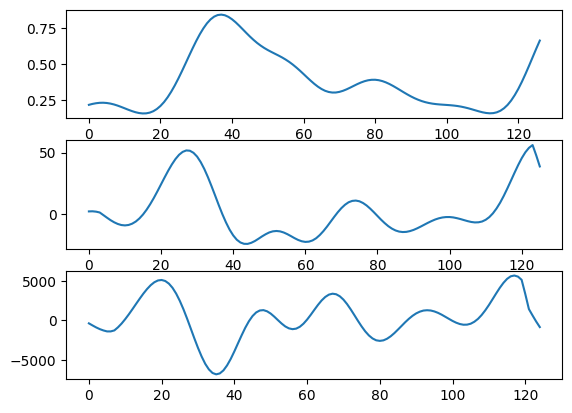

In [181]:
plt.subplot(311)
plt.plot(ppgfeat.seg)
plt.subplot(312)
plt.plot(ppgfeat.VPG)
plt.subplot(313)
plt.plot(ppgfeat.APG)

In [93]:
ppgfeat.PlotButtonPushed()

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

In [105]:
len(ppgfeat.APG)

125

In [113]:
ppgfeat.OSND_time

AttributeError: 'PPGFeat' object has no attribute 'OSND_time'

In [116]:
ppgfeat.APG_maxima,ppgfeat.APG_minima

(array([ 20,  48,  67,  93, 117], dtype=int64),
 array([  5,  35,  56,  80, 103], dtype=int64))

In [156]:
ppgfeat.aEditField, ppgfeat.bEditField,ppgfeat.cEditField, ppgfeat.dEditField, ppgfeat.eEditField

(20, 5, None, None, None)

# retry(upsample to 1000Hz)

In [203]:
# import numpy as np
# from scipy import signal
# import matplotlib.pyplot as plt
# from scipy.signal import find_peaks

# class PPGFeat:
#     def __init__(self):
#         # Initialize properties
#         self.next = 1
#         self.loadedData = None
#         self.PPG_filtered = None
#         self.Size_loaded_data = None
#         self.SEG_min_max = None
#         self.PPG_SEG = None
#         self.APG_SEG = None
#         self.Ssqi = None
#         self.Sub_ID = None
#         self.filter_sos = None
#         self.g = None
#         self.Fs = 1000  # Default sampling frequency
#         self.FL = 0.4   # Default low cutoff frequency
#         self.FH = 8     # Default high cutoff frequency
#         self.T2_5 = None
#         self.SkipSsqiCheckBox  = False
#         self.eEditField = None
#         self.fEditField = None
#         self.dEditField = None
#         self.cEditField = None
#         self.bEditField = None
#         self.aEditField = None
#         self.zEditField = None
#         self.yEditField = None
#         self.xEditField = None
#         self.wEditField = None
#         self.DEditField = None
#         self.NEditField = None
#         self.SEditField = None
#         self.OEditField = None
#         # self.Min1EditField = None
#         # self.Min2EditField = None
        
#     def zerocrossing(self, x):
#         """Find zero crossing points in signal x"""
#         inew = 1
#         r = x
#         loc = [0]
        
#         for ch in range(1, len(r)):
#             if ((r[ch-1] < 0 and r[ch] > 0) or 
#                 (r[ch-1] > 0 and r[ch] < 0)):
#                 loc.append(ch)
#                 inew += 1
                
#         self.zero_c = loc
#         return loc

#     def cal_c_d(self):
#         """Calculate c and d points in APG signal"""
#         z_apg = self.zerocrossing(self.APG)
#         self.JPG = np.diff(self.APG) * 1000
#         self.JPG = pd.Series(self.JPG).rolling(window=85, center=True).mean().to_numpy()
        
#         # Find local maxima and minima
#         max_peaks, _ = signal.find_peaks(self.JPG, prominence=40, distance=50)
#         min_peaks, _ = signal.find_peaks(-self.JPG, prominence=50, distance=50)
        
#         max_value_jpg = max_peaks
#         min_value_jpg = min_peaks
#         z_jpg = self.zerocrossing(self.JPG)
        
#         # Process c and d points based on conditions
#         if len(min_value_jpg) > 1 and self.JPG[min_value_jpg[1]] < 0:
#             if max_value_jpg[0] > min_value_jpg[0]:
#                 self.process_c_d_points(max_value_jpg[0], z_apg[1], z_jpg)
#             elif max_value_jpg[1] > min_value_jpg[0]:
#                 self.process_c_d_points(max_value_jpg[1], z_apg[1], z_jpg)
#             elif max_value_jpg[2] > min_value_jpg[0]:
#                 self.process_c_d_points(max_value_jpg[2], z_apg[1], z_jpg)
                
#         elif len(min_value_jpg) > 1 and self.JPG[min_value_jpg[1]] > 0:
#             if self.APG_maxima[1] < 0:
#                 self.process_c_d_points(self.APG_maxima[1], self.APG_minima[1], z_jpg)
#             elif self.APG_maxima[1] > 0:
#                 self.process_c_d_points(
#                     min_value_jpg[1] - self.T2_5,
#                     min_value_jpg[1] + self.T2_5,
#                     z_jpg
#                 )

#     def process_c_d_points(self, c_point, d_point, z_jpg):
#         """Helper function to process c and d points"""
#         self.cEditField = c_point
#         self.dEditField = d_point
#         self.eEditField = z_jpg[2]
#         f = z_jpg[3]
#         self.fEditField = f
#         self.NEditField = self.eEditField
#         self.DEditField = f

#     def LoadPPGButtonPushed(self, data):
#         """Main function to load and process PPG data"""
#         # Initialize counter
#         self.next = 1
        
#         # # Read filter parameters
#         # self.Fs = self.FsHzEditField
#         # self.FL = self.FLEditField
#         # self.FH = self.FHEditField
        
#         # Load data
#         self.loadedData = data
        
#         # Get data dimensions
#         self.Size_loaded_data = self.loadedData.shape
        
#         # Initialize arrays
#         self.SEG_min_max = np.zeros((self.Size_loaded_data[0], 3))
#         self.PPG_filtered = self.loadedData
#         self.PPG_SEG = np.zeros((self.Size_loaded_data[0], 
#                                 self.Size_loaded_data[1] - self.Size_loaded_data[1]//3))
#         self.APG_SEG = np.zeros_like(self.PPG_SEG)
        
#         # Create filter
#         # sos = signal.cheby2(4, 20, [self.FL, self.FH], 
#         #                   btype='band', fs=self.Fs, output='sos')
        
#         # Apply filter to all data
#         # for i in range(self.Size_loaded_data[0]):
#         #     filtered_data = signal.sosfilt(sos, self.loadedData[i,:])
            
#         #     # Normalize the data
#         #     m = np.mean(filtered_data)
#         #     st = np.std(filtered_data)
#         #     self.PPG_filtered[i,:] = (filtered_data - m) / st
            
#         # Handle Ssqi data if skip option is not checked
#         if not self.SkipSsqiCheckBox:
#             self.handle_ssqi_data()
#         """Plot filtered PPG data and find extrema points"""
#             # Get filtered data for current index
#         filtered_data = self.PPG_filtered[self.next-1, :]
        
#         # Create figure and plot
#         fig, ax = plt.subplots(figsize=(10, 6))
#         ppg_line, = ax.plot(filtered_data)
#         ax.grid(True)
#         ax.set_title('Filtered PPG')
#         ax.set_xlabel('Samples')
#         ax.set_ylabel('Normalized values')
        
#         # Find maxima and minima using find_peaks
#         # For maxima
#         max_peaks, max_properties = signal.find_peaks(
#             filtered_data,
#             prominence=0.1,
#             distance=200,
#             height=None
#         )
#         # Limit to 10 peaks
#         limit  =15
#         if len(max_peaks) > limit:
#             # Sort by prominence and take top 10
#             max_prominences = max_properties['prominences']
#             top_10_max = np.argsort(max_prominences)[-limit:]
#             max_peaks = max_peaks[top_10_max]
        
#         # For minima
#         min_peaks, min_properties = signal.find_peaks(
#             -filtered_data,  # Invert signal to find minima
#             prominence=0.1,
#             distance=100,
#             height=None
#         )
        
#         # Limit to 10 peaks
#         if len(min_peaks) > limit:
#             # Sort by prominence and take top 10
#             min_prominences = min_properties['prominences']
#             top_10_min = np.argsort(min_prominences)[-limit:]
#             min_peaks = min_peaks[top_10_min]
        
#         # Get values at maxima and minima points
#         max_values = filtered_data[max_peaks]
#         min_values = filtered_data[min_peaks]
        
#         # Plot maxima points with annotations
#         if len(max_peaks) > 0:
#             ax.plot(max_peaks, max_values, 'r^', markersize=10)
#             for i, (x, y) in enumerate(zip(max_peaks, max_values)):
#                 ax.annotate(
#                     f'({x}, {y:.2f})',
#                     (x, y),
#                     xytext=(5, 5),
#                     textcoords='offset points',
#                     fontsize=8,
#                     bbox=dict(
#                         boxstyle='round,pad=0.5',
#                         fc='yellow',
#                         alpha=0.5
#                     )
#                 )
        
#         # Plot minima points with annotations
#         if len(min_peaks) > 0:
#             ax.plot(min_peaks, min_values, 'gv', markersize=10)
#             for i, (x, y) in enumerate(zip(min_peaks, min_values)):
#                 ax.annotate(
#                     f'({x}, {y:.2f})',
#                     (x, y),
#                     xytext=(5, -15),  # Offset below point
#                     textcoords='offset points',
#                     fontsize=8,
#                     bbox=dict(
#                         boxstyle='round,pad=0.5',
#                         fc='yellow',
#                         alpha=0.5
#                     )
#                 )
        
#             # Add zoom and pan capabilities
#             # plt.gcf().canvas.toolbar.pan()
#             # plt.gcf().canvas.toolbar.zoom()
            
#             # Set Min1 and Min2 values if minima points exist
#         if len(min_peaks) >= 2:
#             self.Min1EditField = min_peaks[0]
#             self.Min2EditField = min_peaks[1]
        
#         # Initialize variables
#         self.OSND = np.zeros(4)
#         self.WXYZ = np.zeros(4)
#         self.abcde = np.zeros(5)
#         self.feature = np.zeros((219, 30))
#         self.c_d_APG = np.zeros(219)
        
#         # Store peaks for later use
#         self.ppg_max_peaks = max_peaks
#         self.ppg_min_peaks = min_peaks
#         self.ppg_max_values = max_values
#         self.ppg_min_values = min_values
        
#         plt.show()
        
#         return max_peaks, min_peaks, max_values, min_values

#     def handle_ssqi_data(self):
#         """Handle Ssqi data initialization"""
#         A = np.ones(self.Size_loaded_data[0])
#         B = np.arange(1, self.Size_loaded_data[0] + 1)
#         self.Ssqi = np.column_stack((A, B))
        
#         self.SsqiEditField = self.Ssqi[self.next-1, 0]
#         self.Sub_ID = self.Ssqi[self.next-1, 1]
#         self.IDEditField = self.Sub_ID
#     def APG_c_d_test(self):
#         """Test for presence of c and d points in APG"""
#         self.c_d_not = 0
        
#         if self.APG[self.APG_maxima[1]] > 0:  # c and d NOT present in APG
#             self.c_d_not = 1
#             self.c_d_APG[self.next-1] = 0
#             self.canddpresentEditField = self.c_d_APG[self.next-1]
#             self.cal_c_d()
            
#         # Updated on 15th march
#         elif (self.APG[self.APG_maxima[1]] < 0 and 
#               (self.APG_maxima[1] - self.APG_minima[1]) < 100):  # c and d present in APG
#             self.c_d_not = 0
#             self.NEditField = self.APG_maxima[2]
#             self.DEditField = self.APG_minima[2]
#             self.cEditField = self.APG_maxima[1]
#             self.dEditField = self.APG_minima[1]
#             self.eEditField = self.APG_maxima[2]
#             self.fEditField = self.APG_minima[2]
#             self.c_d_APG[self.next-1] = 1
#             self.canddpresentEditField = self.c_d_APG[self.next-1]
#         else:  # Changed 15th march
#             self.c_d_APG[self.next-1] = 1
#             self.canddpresentEditField = self.c_d_APG[self.next-1]
#             self.cal_c_d()

#     def PlotButtonPushed(self):
#         """Plot and analyze PPG segments"""
#         # Set plot lamp indicator
#         self.PlotpressedLamp = 'g'
        
#         # Get segment using manual input values
#         min_padding = 40
#         min1 = self.Min1EditField - min_padding
#         min2 = self.Min2EditField + min_padding
#         self.seg = self.PPG_filtered[self.next-1, min1:min2]
        
#         # Calculate 2.5% of T
#         self.T2_5 = int(((min2 - min1 - 30) / 100) * 2.5)
        
#         # Calculate and filter VPG
#         self.VPG = np.diff(self.seg) * 1000
#         # Smooth data using moving average
#         window = np.ones(50) / 50
#         self.VPG = np.convolve(self.VPG, window, mode='same')
        
#         # Calculate and filter APG
#         self.APG = np.diff(self.VPG) * 1000
#         # Smooth data using moving average
#         window = np.ones(65) / 65
#         self.APG = np.convolve(self.APG, window, mode='same')
        
#         # Create matrix for segment information
#         self.SEG_min_max[self.next-1] = [self.Sub_ID, min1, min2]
        
#         # Find peaks for PPG segment
#         PPG_peaks_max, _ = find_peaks(self.seg, prominence=0.1, distance=10)
#         PPG_peaks_min, _ = find_peaks(-self.seg, prominence=0.01, distance=10)
        
#         # Find peaks for VPG
#         VPG_peaks_max, _ = find_peaks(self.VPG, prominence=0.2, distance=50)
#         VPG_peaks_min, _ = find_peaks(-self.VPG, prominence=0.2, distance=50)
        
#         # Find peaks for APG
#         APG_peaks_max, _ = find_peaks(self.APG, prominence=1.5, distance=50)
#         APG_peaks_min, _ = find_peaks(-self.APG, prominence=1.5, distance=50)
        
#         # Handle close points in APG
#         if len(APG_peaks_min) > 1 and len(APG_peaks_max) > 0:
#             if abs(APG_peaks_min[0] - APG_peaks_max[0]) <= 50:
#                 APG_peaks_min = APG_peaks_min[1:]
        
#         # Store APG maxima and minima
#         self.APG_maxima = APG_peaks_max
#         self.APG_minima = APG_peaks_min
        
#         # Set feature points
#         self.OEditField = PPG_peaks_min[0]
#         self.SEditField = PPG_peaks_max[0]
        
#         # Test for c and d presence
#         self.APG_c_d_test()
        
#         # Set VPG points
#         self.wEditField = VPG_peaks_max[0]
#         self.xEditField = PPG_peaks_max[0]
#         self.yEditField = VPG_peaks_min[0]
#         self.zEditField = VPG_peaks_max[1]
        
#         # Set APG points
#         self.aEditField = APG_peaks_max[0]
#         self.bEditField = APG_peaks_min[0]
        
#         # Store feature values
#         self.store_feature_values()
        
#         # Plot results
#         self.plot_results(PPG_peaks_max, PPG_peaks_min, 
#                          VPG_peaks_max, VPG_peaks_min,
#                          APG_peaks_max, APG_peaks_min)

#     def store_feature_values(self):
#         """Store feature values for all waveforms"""
#         # PPG features
#         self.OSND = [
#             self.seg[self.OEditField],
#             self.seg[self.SEditField],
#             self.seg[self.NEditField],
#             self.seg[self.DEditField]
#         ]
        
#         # VPG features
#         self.WXYZ = [
#             self.VPG[self.wEditField],
#             self.VPG[self.xEditField],
#             self.VPG[self.yEditField],
#             self.VPG[self.zEditField]
#         ]
        
#         # APG features
#         self.abcde = [
#             self.APG[self.aEditField],
#             self.APG[self.bEditField],
#             self.APG[self.cEditField],
#             self.APG[self.dEditField],
#             self.APG[self.eEditField]
#         ]
        
#         # Time variables
#         self.OSND_time = [self.OEditField, self.SEditField, 
#                          self.NEditField, self.DEditField]
#         self.WXYZ_time = [self.wEditField, self.xEditField, 
#                          self.yEditField, self.zEditField]
#         self.abcde_time = [self.aEditField, self.bEditField,
#                           self.cEditField, self.dEditField, 
#                           self.eEditField]
        
#         # Additional features
#         F_Value = self.APG[self.fEditField]
#         F_t = self.fEditField
#         O_next_t = ((self.Min2EditField - self.Min1EditField) + 16)
#         O_next = self.seg[O_next_t]
        
#         # Store all features
#         self.feature[self.next-1] = np.concatenate([
#             self.OSND,
#             [O_next],
#             self.WXYZ,
#             self.abcde,
#             [F_Value],
#             self.OSND_time,
#             [O_next_t],
#             self.WXYZ_time,
#             self.abcde_time,
#             [F_t]
#         ])

#     def plot_results(self, PPG_peaks_max, PPG_peaks_min, 
#                     VPG_peaks_max, VPG_peaks_min,
#                     APG_peaks_max, APG_peaks_min):
#         """Plot all waveforms with their features"""
#         fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
        
#         # Plot PPG
#         ax1.plot(self.seg)
#         ax1.plot(PPG_peaks_max, self.seg[PPG_peaks_max], "x")
#         ax1.plot(PPG_peaks_min, self.seg[PPG_peaks_min], "o")
#         ax1.axhline(y=0, color='r', linestyle='--')
#         ax1.set_title('PPG Segment')
#         ax1.grid(True)
        
#         # Plot VPG
#         ax2.plot(self.VPG)
#         ax2.plot(VPG_peaks_max, self.VPG[VPG_peaks_max], "x")
#         ax2.plot(VPG_peaks_min, self.VPG[VPG_peaks_min], "o")
#         ax2.axhline(y=0, color='r', linestyle='--')
#         ax2.set_title('VPG')
#         ax2.grid(True)
        
#         # Plot APG
#         ax3.plot(self.APG)
#         ax3.plot(APG_peaks_max, self.APG[APG_peaks_max], "x")
#         ax3.plot(APG_peaks_min, self.APG[APG_peaks_min], "o")
#         ax3.axhline(y=0, color='r', linestyle='--')
#         ax3.set_title('APG')
#         ax3.grid(True)
        
#         plt.tight_layout()
#         plt.show()
        
#         # Store segments
#         pad_length = self.Size_loaded_data[1] - 700 - len(self.seg)
#         self.PPG_SEG[self.next-1] = np.pad(self.seg, (0, pad_length))
#         self.APG_SEG[self.next-1] = np.pad(self.APG, (0, pad_length))

        
#     def APG_c_d_test(self):
#         """Test for presence of c and d points in APG"""
#         self.c_d_not = 0
        
#         if self.APG[self.APG_maxima[1]] > 0:  # c and d NOT present in APG
#             self.c_d_not = 1
#             self.c_d_APG[self.next-1] = 0
#             self.canddpresentEditField = self.c_d_APG[self.next-1]
#             self.cal_c_d()
            
#         # Updated on 15th march
#         elif (self.APG[self.APG_maxima[1]] < 0 and 
#               (self.APG_maxima[1] - self.APG_minima[1]) < 100):  # c and d present in APG
#             self.c_d_not = 0
#             self.NEditField = self.APG_maxima[2]
#             self.DEditField = self.APG_minima[2]
#             self.cEditField = self.APG_maxima[1]
#             self.dEditField = self.APG_minima[1]
#             self.eEditField = self.APG_maxima[2]
#             self.fEditField = self.APG_minima[2]
#             self.c_d_APG[self.next-1] = 1
#             self.canddpresentEditField = self.c_d_APG[self.next-1]
#         else:  # Changed 15th march
#             self.c_d_APG[self.next-1] = 1
#             self.canddpresentEditField = self.c_d_APG[self.next-1]
#             self.cal_c_d()

#     def PlotButtonPushed(self):
#         """Plot and analyze PPG segments"""
#         # Set plot lamp indicator
#         self.PlotpressedLamp = 'g'
        
#         # Get segment using manual input values
#         min1 = self.Min1EditField - 15
#         min2 = self.Min2EditField + 15
#         self.seg = self.PPG_filtered[self.next-1, min1:min2]
        
#         # Calculate 2.5% of T
#         self.T2_5 = int(((min2 - min1 - 30) / 100) * 2.5)
        
#         # Calculate and filter VPG
#         self.VPG = np.diff(self.seg) * 1000
#         # Smooth data using moving average
#         window = np.ones(50) / 50
#         self.VPG = np.convolve(self.VPG, window, mode='same')
        
#         # Calculate and filter APG
#         self.APG = np.diff(self.VPG) * 1000
#         # Smooth data using moving average
#         window = np.ones(65) / 65
#         self.APG = np.convolve(self.APG, window, mode='same')
        
#         # Create matrix for segment information
#         self.SEG_min_max[self.next-1] = [self.Sub_ID, min1, min2]
        
#         # Find peaks for PPG segment
#         PPG_peaks_max, _ = find_peaks(self.seg, prominence=0.1, distance=10)
#         PPG_peaks_min, _ = find_peaks(-self.seg, prominence=0.01, distance=10)
        
#         # Find peaks for VPG
#         VPG_peaks_max, _ = find_peaks(self.VPG, prominence=0.2, distance=50)
#         VPG_peaks_min, _ = find_peaks(-self.VPG, prominence=0.2, distance=50)
        
#         # Find peaks for APG
#         APG_peaks_max, _ = find_peaks(self.APG, prominence=1.5, distance=50)
#         APG_peaks_min, _ = find_peaks(-self.APG, prominence=1.5, distance=50)
        
#         # Handle close points in APG
#         if len(APG_peaks_min) > 1 and len(APG_peaks_max) > 0:
#             if abs(APG_peaks_min[0] - APG_peaks_max[0]) <= 50:
#                 APG_peaks_min = APG_peaks_min[1:]
        
#         # Store APG maxima and minima
#         self.APG_maxima = APG_peaks_max
#         self.APG_minima = APG_peaks_min
        
#         # Set feature points
#         self.OEditField = PPG_peaks_min[0]
#         self.SEditField = PPG_peaks_max[0]
        
#         # Test for c and d presence
#         self.APG_c_d_test()
        
#         # Set VPG points
#         self.wEditField = VPG_peaks_max[0]
#         self.xEditField = PPG_peaks_max[0]
#         self.yEditField = VPG_peaks_min[0]
#         self.zEditField = VPG_peaks_max[1]
        
#         # Set APG points
#         self.aEditField = APG_peaks_max[0]
#         self.bEditField = APG_peaks_min[0]
        
#         # Store feature values
#         self.store_feature_values()
        
#         # Plot results
#         self.plot_results(PPG_peaks_max, PPG_peaks_min, 
#                         VPG_peaks_max, VPG_peaks_min,
#                         APG_peaks_max, APG_peaks_min)

#     def store_feature_values(self):
#         """Store feature values for all waveforms"""
#         # PPG features
#         self.OSND = [
#             self.seg[self.OEditField],
#             self.seg[self.SEditField],
#             self.seg[self.NEditField],
#             self.seg[self.DEditField]
#         ]
        
#         # VPG features
#         self.WXYZ = [
#             self.VPG[self.wEditField],
#             self.VPG[self.xEditField],
#             self.VPG[self.yEditField],
#             self.VPG[self.zEditField]
#         ]
        
#         # APG features
#         self.abcde = [
#             self.APG[self.aEditField],
#             self.APG[self.bEditField],
#             self.APG[self.cEditField],
#             self.APG[self.dEditField],
#             self.APG[self.eEditField]
#         ]
        
#         # Time variables
#         self.OSND_time = [self.OEditField, self.SEditField, 
#                         self.NEditField, self.DEditField]
#         self.WXYZ_time = [self.wEditField, self.xEditField, 
#                         self.yEditField, self.zEditField]
#         self.abcde_time = [self.aEditField, self.bEditField,
#                         self.cEditField, self.dEditField, 
#                         self.eEditField]
        
#         # Additional features
#         F_Value = self.APG[self.fEditField]
#         F_t = self.fEditField
#         O_next_t = ((self.Min2EditField - self.Min1EditField) + 16)
#         O_next = self.seg[O_next_t]
        
#         # Store all features
#         self.feature[self.next-1] = np.concatenate([
#             self.OSND,
#             [O_next],
#             self.WXYZ,
#             self.abcde,
#             [F_Value],
#             self.OSND_time,
#             [O_next_t],
#             self.WXYZ_time,
#             self.abcde_time,
#             [F_t]
#         ])

#     def plot_results(self, PPG_peaks_max, PPG_peaks_min, 
#                     VPG_peaks_max, VPG_peaks_min,
#                     APG_peaks_max, APG_peaks_min):
#         """Plot all waveforms with their features"""
#         fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16))
        
#         # Plot PPG
#         ax1.plot(self.seg)
#         ax1.plot(PPG_peaks_max[0], self.seg[PPG_peaks_max[0]], "s",color="black")
#         ax1.annotate('S', (PPG_peaks_max[0], self.seg[PPG_peaks_max[0]]), xytext=(5,5), textcoords='offset points')
#         ax1.plot(PPG_peaks_min[0], self.seg[PPG_peaks_min[0]], "s",color="black")
#         ax1.annotate('O', (PPG_peaks_min[0], self.seg[PPG_peaks_min[0]]), xytext=(5,5), textcoords='offset points')
#         ax1.plot(self.eEditField, self.seg[self.eEditField], "s",color="brown")
#         ax1.annotate('N', (self.eEditField, self.seg[self.eEditField]), xytext=(5,5), textcoords='offset points')
#         ax1.plot(self.fEditField, self.seg[self.fEditField], "s",color="brown")
#         ax1.annotate('D', (self.fEditField, self.seg[self.fEditField]), xytext=(5,5), textcoords='offset points')

#         ax1.axhline(y=0, color='r', linestyle='--')
#         ax1.legend()
#         ax1.set_title('PPG Segment')
#         ax1.grid(True)
        
#         # Plot VPG
#         ax2.plot(self.VPG)
#         ax2.plot(VPG_peaks_max, self.VPG[VPG_peaks_max], "x",label="local maxima")
#         ax2.plot(VPG_peaks_min, self.VPG[VPG_peaks_min], "o",label="local minima")
#         ax2.plot(self.wEditField, self.VPG[self.wEditField], "s",color="black")
#         ax2.annotate('W', (self.wEditField, self.VPG[self.wEditField]), xytext=(5,5), textcoords='offset points')
#         ax2.plot(self.xEditField, self.VPG[self.xEditField], "s",color="black")
#         ax2.annotate('X', (self.xEditField, self.VPG[self.xEditField]), xytext=(5,5), textcoords='offset points')
#         ax2.plot(self.yEditField, self.VPG[self.yEditField], "s",color="gray")
#         ax2.annotate('Y', (self.yEditField, self.VPG[self.yEditField]), xytext=(5,5), textcoords='offset points')
#         ax2.plot(self.zEditField, self.VPG[self.zEditField], "s",color="gray")
#         ax2.annotate('Z', (self.zEditField, self.VPG[self.zEditField]), xytext=(5,5), textcoords='offset points')

#         ax2.axhline(y=0, color='r', linestyle='--')
#         ax2.legend()
#         ax2.set_title('VPG')
#         ax2.grid(True)
        
#         # Plot APG
#         ax3.plot(self.APG)
#         ax3.plot(APG_peaks_max, self.APG[APG_peaks_max], "x",label="local maxima")
#         ax3.plot(APG_peaks_min, self.APG[APG_peaks_min], "o",label="local minima")
#         ax3.plot(self.aEditField, self.APG[self.aEditField], "s",color="black")
#         ax3.annotate('a', (self.aEditField, self.APG[self.aEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.bEditField, self.APG[self.bEditField], "s",color="black")
#         ax3.annotate('b', (self.bEditField, self.APG[self.bEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.cEditField, self.APG[self.cEditField], "s",color="gray")
#         ax3.annotate('c', (self.cEditField, self.APG[self.cEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.dEditField, self.APG[self.dEditField], "s",color="gray")
#         ax3.annotate('d', (self.dEditField, self.APG[self.dEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.eEditField, self.APG[self.eEditField], "s",color="brown")
#         ax3.annotate('e', (self.eEditField, self.APG[self.eEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.fEditField, self.APG[self.fEditField], "s",color="brown")
#         ax3.annotate('f', (self.fEditField, self.APG[self.fEditField]), xytext=(5,5), textcoords='offset points')

#         ax3.axhline(y=0, color='r', linestyle='--')
#         ax3.set_title('APG')
#         ax3.grid(True)
#         ax3.legend()        
        
#         ax4.plot(self.JPG)
#         ax4.plot(APG_peaks_max, self.APG[APG_peaks_max], "x",label="local maxima")
#         ax4.plot(APG_peaks_min, self.APG[APG_peaks_min], "o",label="local minima")
#         ax4.plot(self.aEditField, self.APG[self.aEditField], "s",color="black")
#         ax4.annotate('a', (self.aEditField, self.APG[self.aEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.bEditField, self.APG[self.bEditField], "s",color="black")
#         ax3.annotate('b', (self.bEditField, self.APG[self.bEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.cEditField, self.APG[self.cEditField], "s",color="gray")
#         ax3.annotate('c', (self.cEditField, self.APG[self.cEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.dEditField, self.APG[self.dEditField], "s",color="gray")
#         ax3.annotate('d', (self.dEditField, self.APG[self.dEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.eEditField, self.APG[self.eEditField], "s",color="brown")
#         ax3.annotate('e', (self.eEditField, self.APG[self.eEditField]), xytext=(5,5), textcoords='offset points')
#         ax3.plot(self.fEditField, self.APG[self.fEditField], "s",color="brown")
#         ax3.annotate('f', (self.fEditField, self.APG[self.fEditField]), xytext=(5,5), textcoords='offset points')

#         ax3.axhline(y=0, color='r', linestyle='--')
#         ax3.set_title('APG')
#         ax3.grid(True)
#         ax3.legend()
#         plt.tight_layout()
#         plt.show()
#         plt.tight_layout()
#         plt.show()
        
#         # Store segments
#         pad_length =  self.PPG_SEG[self.next-1].shape[0]-self.seg.shape[0]
#         print(pad_length,self.Size_loaded_data[1],"array ", self.PPG_SEG[self.next-1].shape,"seg",self.seg.shape)
#         self.PPG_SEG[self.next-1] = np.pad(self.seg, (0, pad_length))
#         self.APG_SEG[self.next-1] = np.pad(self.APG, (0, pad_length+2))

##  code

In [211]:
data = np.load("../data/processed/BP_npy/PulseDB/test.npy")[:,1]
data.shape

(111600, 1250)

In [123]:
from scipy.signal import resample
fs_in = 125         # 元のサンプリングレート
fs_out = 1000       # 新しいサンプリングレート
duration = 1000 / fs_in  # 秒数（8秒）
n_out = int(duration * fs_out)  # アップサンプリング後の点数 = 8000
signal_1000hz = resample(data, n_out,axis=1)

In [100]:
signal_1000hz.shape

(111600, 8000)

minima 2 exist


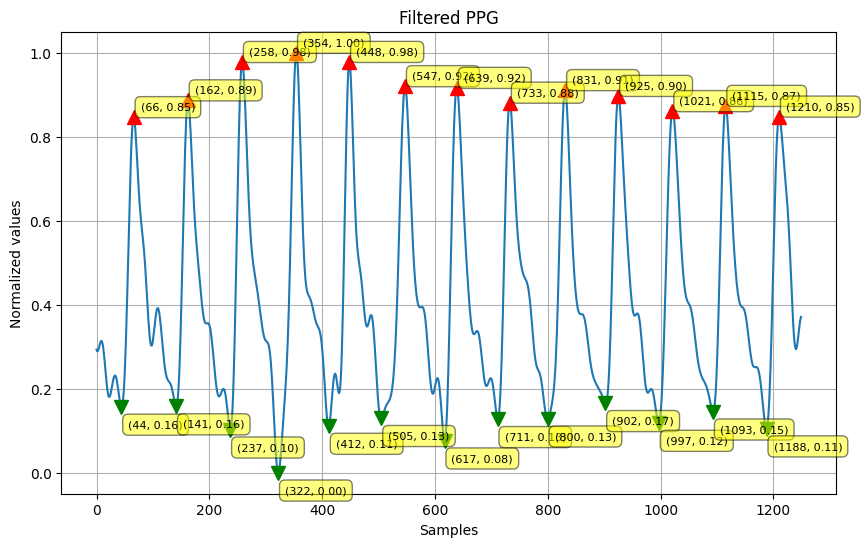

array([[0.29327659, 0.28963063, 0.28925258, ..., 0.35876593, 0.36643192,
        0.37076879],
       [0.71153933, 0.77107217, 0.82469271, ..., 0.14430031, 0.13448586,
        0.12478678],
       [0.44093369, 0.50093233, 0.56322835, ..., 0.76776474, 0.70136231,
        0.63471129],
       ...,
       [0.01364501, 0.0112742 , 0.00972349, ..., 0.39549545, 0.37097273,
        0.34608265],
       [0.90771839, 0.89216977, 0.86967031, ..., 0.92178301, 0.92996273,
        0.92819919],
       [0.14134978, 0.13368435, 0.12889229, ..., 0.75331865, 0.77155199,
        0.78134268]])

In [232]:
ppgfeat =PPGFeat()
# ppgfeat.LoadPPGButtonPushed(signal_1000hz[:1000])
ppgfeat.LoadPPGButtonPushed(data[:1000])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1 3 3 2 4 4
4 -574368.6698020805
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'int'> <class 'int'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'int'> <class 'int'> <class 'int'> 

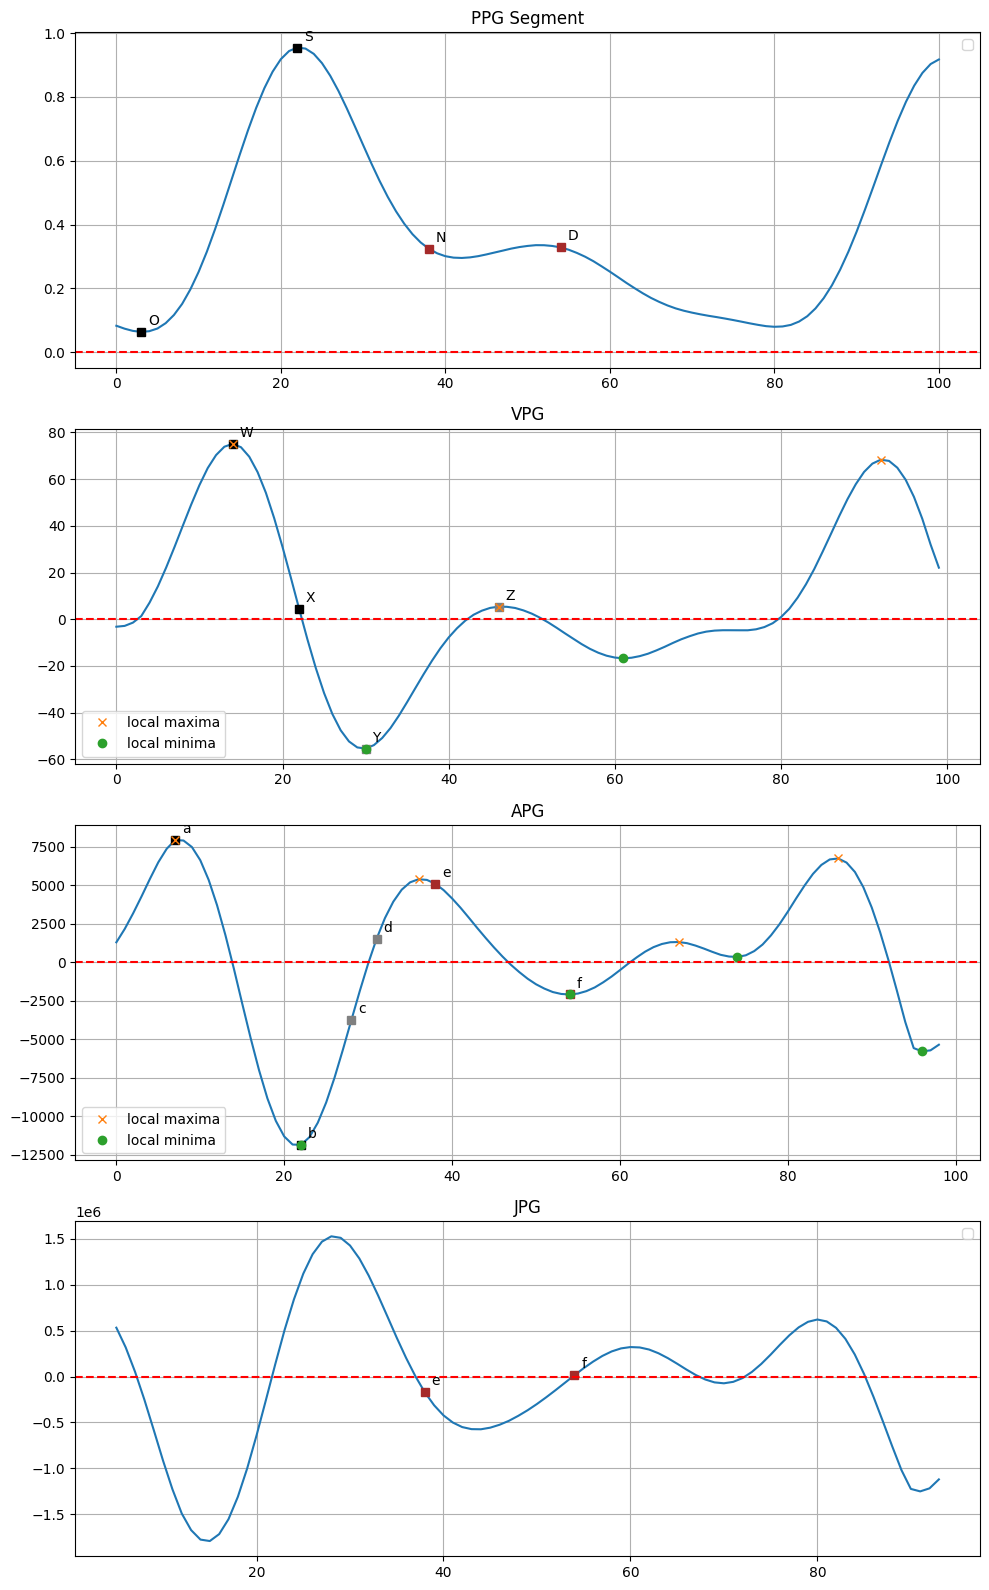

<Figure size 640x480 with 0 Axes>

733 1250 array  (834,) seg (101,)
2563.8384825644666 -171018.27878815797


In [239]:
ppgfeat.PlotButtonPushed()
print(ppgfeat.JPG[ppgfeat.eEditField-1],ppgfeat.JPG[ppgfeat.eEditField])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1 3 3 2 4 4
4 -574368.6698020805
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'int'> <class 'int'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'numpy.int64'> <class 'int'> <class 'int'> <class 'int'> 

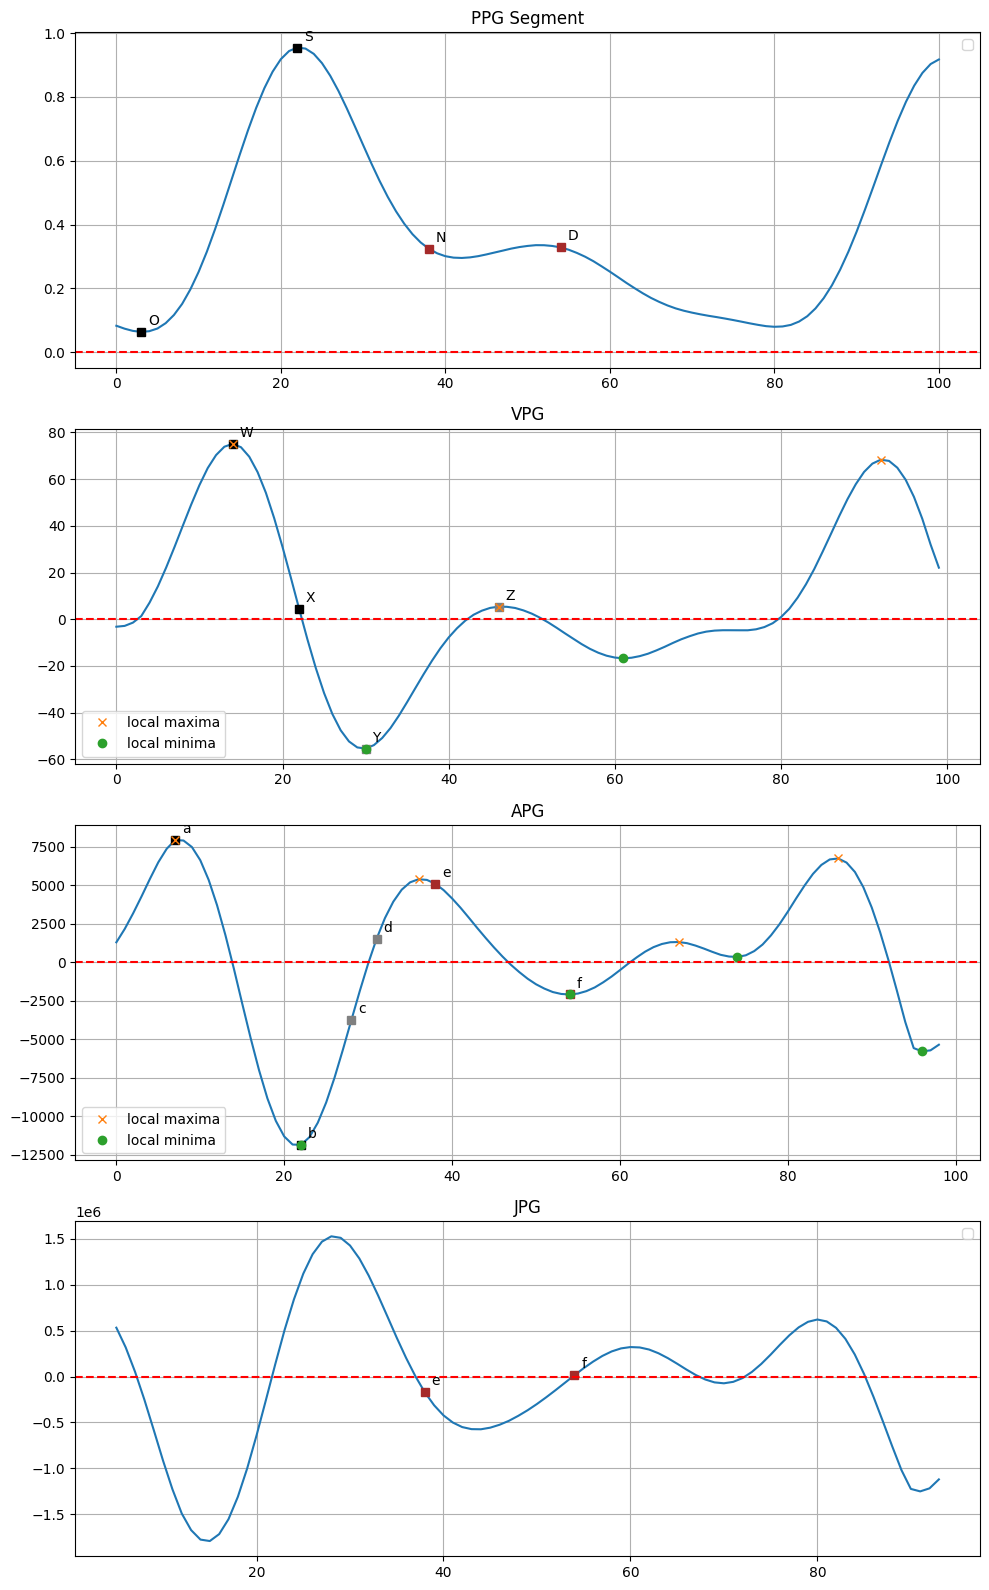

<Figure size 640x480 with 0 Axes>

733 1250 array  (834,) seg (101,)


In [237]:
ppgfeat.next += 1
ppgfeat.PlotButtonPushed()

## For loop

In [298]:
from tqdm import trange
def segmentation_loop():
    ppgfeat = PPGFeat()
    data = np.load("../data/processed/BP_npy/PulseDB/test.npy")[:,1]
    print(data.shape)
    all_features = pd.DataFrame()
    ppgfeat.LoadPPGButtonPushed(data,do_plot=False)
    for i in trange(len(data)):
        ppgfeat.next = i-1
        while(ppgfeat.update()):
            ppgfeat.PlotButtonPushed(do_plot=False)
            features = ppgfeat.store_feature_values()
            all_features = pd.concat([all_features, features], ignore_index=True)
        ppgfeat.LoadPPGButtonPushed(data,do_plot=False,skip_init=True)
    # try:
    #     for i in tqdm(range(1,len(data)+1)):
    #         ppgfeat.next = i
    #         while(ppgfeat.update()):
    #             ppgfeat.PlotButtonPushed(do_plot=False)
    #             features = ppgfeat.store_feature_values()
    #             all_features = pd.concat([all_features, features], ignore_index=True)
    # except Exception as e:
    #     all_features.to_csv("../data/processed/csv/PulseDB/ppg_seg_test.csv")
    #     print(e)
    return all_features

In [299]:
df = segmentation_loop()
df.to_csv("../data/processed/csv/PulseDB/ppg_seg_test.csv")

(111600, 1250)


  0%|          | 2/111600 [00:00<14:52, 125.00it/s]

minima 2 exist, num of peaks: 13
minima 2 exist, num of peaks: 12
minima 2 exist, num of peaks: 11
minima 2 exist, num of peaks: 10
minima 2 exist, num of peaks: 9
minima 2 exist, num of peaks: 8
minima 2 exist, num of peaks: 7
minima 2 exist, num of peaks: 6
minima 2 exist, num of peaks: 5
minima 2 exist, num of peaks: 4
minima 2 exist, num of peaks: 3
minima 2 exist, num of peaks: 2
minima 2 doesn't exist, num of peaks: 1
minima 2 exist, num of peaks: 14
minima 2 exist, num of peaks: 13
minima 2 exist, num of peaks: 12
minima 2 exist, num of peaks: 11
minima 2 exist, num of peaks: 10
minima 2 exist, num of peaks: 9
minima 2 exist, num of peaks: 8
minima 2 exist, num of peaks: 7
minima 2 exist, num of peaks: 6
minima 2 exist, num of peaks: 5
minima 2 exist, num of peaks: 4
minima 2 exist, num of peaks: 3
minima 2 exist, num of peaks: 2
minima 2 doesn't exist, num of peaks: 1
minima 2 exist, num of peaks: 15
minima 2 exist, num of peaks: 14
minima 2 exist, num of peaks: 13
minima 2 exi

ValueError: v cannot be empty

In [264]:
ppgfeat.ppg_peaks_max

AttributeError: 'PPGFeat' object has no attribute 'ppg_peaks_max'